In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

This notebook shows how to compute a route tree using the real data for California using various objectives and methods. Using this nodebook requires the computation of an RSNG useing the Make_Empty_Graph and Add_Adjecency notebooks.

The routing methods are implementations of Dijkstra's and Bellman's methods. Each implementation depends on an Objective object which contains the following four functions:

values = initial() - Function which produces the starting values of each problem state to be applied to the origin node(s)

values = infinity() - Function which produces the starting values for each non-origin node. The values should be intialized such that they are at least higher than any conceivable value which could be attained during routing.

values, feasible = update(values, edge, node) - Function which takes current path state values and updates them based on the edge traversed and the target node and whether the proposed edge traversal is feasible. This function returns the values argument and a boolean feasible.

values, savings = compare(values, approximation) - Function for comparing path state values with the existing best approximation at the target node. This function returns the values argument and a boolean savings.

values may be of any type as long is that type is consistently applied. 

The Dijkstra and Bellman methods are closely related and both are methods of successive approximation. Both methods initialize a graph by approximating the cost of reaching each non-origin node as infinity. Through iteration the costs-to-reach are updated until all reachable nodes have been visited. Dijkstra's method is a generalization of a greedy solution wherein, starting from the origin, the closest un-visited node is selected and the path from the origin through the selected node to all nodes adjacent to the selected node is compared to the best existing approximation. Bellman's method is an implementation of the Hamilton-Jacobi-Bellman principle of optimality which states that the cost of an action is the sum of the costs of that action and the optimal action at the next step as a result of that action. Thus, Bellman's method iterates through all nodes in the graph and seeks to find the optimal predecessor node for each non-origin node. An optimal path for any destination can, then, be found by traceback to the origin.

Both the Dijkstra and Bellman methods will produce the same solution in most cases. The methods will behave differently if thre are negative-cost edge loops - an unlikely phenomenon in vehicle routing. In general, Dijkstra's method will be faster for graphs with a high edge-to-node ratio and the opposite is true for graphs with a low edge-to-node ratio. In this repository the creation of the network RSNG is based on a roadmap and thus Dijkstra's method is faster. However, routing along the RSNG favors Bellman's method as demonstrated in this nodebook.

There are three objectives deployed in this nodebook. The first is the simplest possible objective defined in src.routing.Objective which tracks either pure network distance or a single attribute. This objective mirrors the function of NetworkX's implementation of the routing methods. The second is src.routing.Vehicle which represents a limited-range vehicle which may add range at stations. The third is src.routing.StochasticVehicle which represents a limited-range vehicle which deals with uncertain edge and node costs. Stochastic routing relies on StochasticStation objects at nodes.

In [2]:
'''
Loading the graph with adjacency

graph contains 15 cities in cities.json and all CA DC charging stations from AFDC
'''

graph = src.graph.graph_from_json('Outputs/graph_full.json')

FileNotFoundError: [Errno 2] No such file or directory: 'Outputs/graph_full.json'

In [96]:
for source, adj in graph._adj.items():
    for target, edge in adj.items():
        
        graph._node[source]['time'] = 0
        graph._node[source]['distance'] = 0
        graph._node[source]['price'] = 0

        graph._node[target]['time'] = 0
        graph._node[target]['distance'] = 0
        graph._node[target]['price'] = 0

        edge['price'] = 0

        if ('station' in source):

            graph._node[source]['type'] = 'station'

        else:

            graph._node[source]['type'] = 'city'

        if ('station' in source) and ('station' in target):
            
            edge['type'] = 'station_station'

        elif ('station' in source) or ('station' in target):

            edge['type'] = 'city_station'
            
        else:
            
            edge['type'] = 'city_city'

In [23]:
'''
Running with Dijkstra with default objective
'''
deep_reload(src)

objective = src.dijkstra.Objective(field = 'time')

t0 = time.time()

r = src.dijkstra.dijkstra(
    graph, ['Fresno'], objective = objective, return_paths = True
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 2.6532 seconds


In [24]:
print('Total Time:\n')
pprint({k: v / 3600 for k, v in r[1].items() if 'station' not in k})

Total Time:

{'Bakersfield': 1.6082676698301681,
 'Chico': 4.230472506660002,
 'Crescent City': 8.605738955488926,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 6.647205294705284,
 'I-15 to Las Vegas (State Line)': 5.727073083166826,
 'I-80 to Reno (State Line)': 4.53776988636363,
 'Los Angeles': 3.263417207792204,
 'Redding': 5.118724469974463,
 'Sacramento': 2.6713354700854657,
 'San Diego': 5.252874417249402,
 'San Francisco': 2.9443037864912807,
 'San Jose': 2.5138573648573628,
 'Stockton': 1.9591595904095878,
 'Yreka': 6.610469062187799}


In [21]:
'''
Running with Dijkstra with deterministic vehicle objective
'''
deep_reload(src)

objective = src.routing.Vehicle(capacity = 80 * 3.6e6)

t0 = time.time()

r = src.dijkstra.dijkstra(graph, ['Fresno'], objective = objective, return_paths = True)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 15.8576 seconds


In [22]:
print('Total Time:\n')
pprint({k: v['time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nDriving Time:\n')
pprint({k: v['driving_time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in r[2].items() if 'station' not in k})

Total Time:

{'Bakersfield': 1.6082676698301694,
 'Chico': 4.23047250666002,
 'Crescent City': 9.353999372155622,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 7.146036891927523,
 'I-15 to Las Vegas (State Line)': 5.916281416500174,
 'I-80 to Reno (State Line)': 4.5377698863636535,
 'Los Angeles': 3.263417207792208,
 'Redding': 5.228450164418934,
 'Sacramento': 2.6713354700854763,
 'San Diego': 5.380952542249436,
 'San Francisco': 2.9443037864912918,
 'San Jose': 2.513857364857367,
 'Stockton': 1.9591595904095913,
 'Yreka': 7.018837117743368}

Driving Time:

{'Bakersfield': 1.6082676698301694,
 'Chico': 4.23047250666002,
 'Crescent City': 8.605738955488954,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 6.647205294705299,
 'I-15 to Las Vegas (State Line)': 5.7270730831668395,
 'I-80 to Reno (State Line)': 4.5377698863636535,
 'Los Angeles': 3.263417207792208,
 'Redding': 5.118724469974489,
 'Sacramento': 2.6713354700854763,
 'San Diego': 5.252874417249437,
 'San Francisco': 2.9443

In [25]:
'''
Running with Bellman with default objective
'''
deep_reload(src)

objective = src.bellman.Objective(field = 'time')

t0 = time.time()

r = src.bellman.bellman(graph, ['Fresno'], objective = objective, return_paths = True)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 3.3767 seconds


In [26]:
print('Total Time:\n')
pprint({k: v / 3600 for k, v in r[1].items() if 'station' not in k})

Total Time:

{'Bakersfield': 1.6082676698301681,
 'Chico': 4.230472506660002,
 'Crescent City': 8.605738955488926,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 6.647205294705284,
 'I-15 to Las Vegas (State Line)': 5.727073083166826,
 'I-80 to Reno (State Line)': 4.53776988636363,
 'Los Angeles': 3.263417207792204,
 'Redding': 5.118724469974463,
 'Sacramento': 2.6713354700854657,
 'San Diego': 5.252874417249402,
 'San Francisco': 2.9443037864912807,
 'San Jose': 2.5138573648573628,
 'Stockton': 1.9591595904095878,
 'Yreka': 6.610469062187799}


In [44]:
'''
Running with Bellman with BEV vehicle objective
'''
deep_reload(src)

objective = src.routing.Vehicle(capacity = 80 * 3.6e6)

t0 = time.time()

r = src.bellman.bellman(
    graph, ['Fresno'], objective = objective, return_paths = True
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 3.6547 seconds


In [45]:
print('Total Time:\n')
pprint({k: v['time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nDriving Time:\n')
pprint({k: v['driving_time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in r[2].items() if 'station' not in k})

Total Time:

{'Bakersfield': 1.6082676698301694,
 'Chico': 4.23047250666002,
 'Crescent City': 9.353999372155622,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 7.146036891927523,
 'I-15 to Las Vegas (State Line)': 5.916281416500174,
 'I-80 to Reno (State Line)': 4.5377698863636535,
 'Los Angeles': 3.263417207792208,
 'Redding': 5.228450164418934,
 'Sacramento': 2.6713354700854763,
 'San Diego': 5.380952542249436,
 'San Francisco': 2.9443037864912918,
 'San Jose': 2.513857364857367,
 'Stockton': 1.9591595904095913,
 'Yreka': 7.018837117743368}

Driving Time:

{'Bakersfield': 1.6082676698301694,
 'Chico': 4.23047250666002,
 'Crescent City': 8.605738955488954,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 6.647205294705299,
 'I-15 to Las Vegas (State Line)': 5.7270730831668395,
 'I-80 to Reno (State Line)': 4.5377698863636535,
 'Los Angeles': 3.263417207792208,
 'Redding': 5.118724469974489,
 'Sacramento': 2.6713354700854763,
 'San Diego': 5.252874417249437,
 'San Francisco': 2.9443

In [29]:
'''
Running with Bellman with ICEV vehicle objective
'''
deep_reload(src)

objective = src.routing.Vehicle(
    capacity = 528 * 3.6e6,
    efficiency = 550 * 5,
    charge_rate = 14.15e6,
    charge_time_penalty = 300,
)

t0 = time.time()

r = src.bellman.bellman(
    graph, ['Fresno'], objective = objective, return_paths = True
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 5.9471 seconds


In [30]:
print('Total Time:\n')
pprint({k: v['time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nDriving Time:\n')
pprint({k: v['driving_time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in r[2].items() if 'station' not in k})

Total Time:

{'Bakersfield': 1.6082676698301694,
 'Chico': 4.23047250666002,
 'Crescent City': 8.69826054952113,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 6.731803498474445,
 'I-15 to Las Vegas (State Line)': 5.727073083166839,
 'I-80 to Reno (State Line)': 4.5377698863636535,
 'Los Angeles': 3.263417207792208,
 'Redding': 5.11872446997449,
 'Sacramento': 2.6713354700854763,
 'San Diego': 5.252874417249402,
 'San Francisco': 2.9443037864912918,
 'San Jose': 2.513857364857367,
 'Stockton': 1.9591595904095913,
 'Yreka': 6.628059943528701}

Driving Time:

{'Bakersfield': 1.6082676698301694,
 'Chico': 4.23047250666002,
 'Crescent City': 8.605738955488937,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 6.647205294705305,
 'I-15 to Las Vegas (State Line)': 5.727073083166839,
 'I-80 to Reno (State Line)': 4.5377698863636535,
 'Los Angeles': 3.263417207792208,
 'Redding': 5.11872446997449,
 'Sacramento': 2.6713354700854763,
 'San Diego': 5.252874417249402,
 'San Francisco': 2.94430378

In [4]:
'''
Adding station objects
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    capacity = 80 * 3.6e6,
    max_charge_start_soc = .4,
)

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            vehicle, chargers = node['n_dcfc']
        )

In [78]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

t0 = time.time()

r = src.bellman.bellman(
    graph, ['Fresno'], objective = vehicle, return_paths = True
)


print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 271.3777 seconds


In [79]:
print('Total Time:\n')
pprint({k: v['time'].mean() / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nDriving Time:\n')
pprint({k: v['driving_time'].mean() / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in r[2].items() if 'station' not in k})

Total Time:

{'Bakersfield': 1.6082676698301688,
 'Chico': 4.230472506660022,
 'Crescent City': 9.322327309899501,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 7.333510387976293,
 'I-15 to Las Vegas (State Line)': 6.5289475195129185,
 'I-80 to Reno (State Line)': 4.537769886363654,
 'Los Angeles': 3.2634172077922083,
 'Redding': 5.796630054177901,
 'Sacramento': 2.671335470085476,
 'San Diego': 5.9207782571307535,
 'San Francisco': 2.944303786491293,
 'San Jose': 2.513857364857368,
 'Stockton': 1.9591595904095918,
 'Yreka': 7.288374646391242}

Driving Time:

{'Bakersfield': 1.6082676698301688,
 'Chico': 4.230472506660022,
 'Crescent City': 8.60573895548895,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 6.661848151848151,
 'I-15 to Las Vegas (State Line)': 5.727073083166832,
 'I-80 to Reno (State Line)': 4.537769886363654,
 'Los Angeles': 3.2634172077922083,
 'Redding': 5.118724469974474,
 'Sacramento': 2.671335470085476,
 'San Diego': 5.268407634032647,
 'San Francisco': 2.94430

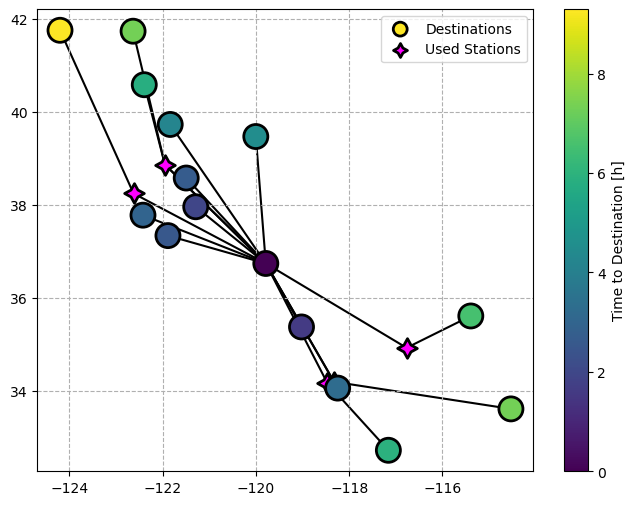

In [22]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if 'station' not in k]

src.figures.plot_route_tree(
    ax, graph,
    {k: v['time'].mean() / 3600 for k, v in r[1].items()},
    # {},
    {k: v for k, v in r[2].items() if 'station' not in k},
    destinations = destinations,
    show_unused_stations = False,
    **src.figures.default_route_tree_kwargs,
)

# _ = ax.set(**{
#     'xticks': np.linspace(-5e5, 5e5, 11),
#     'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
#     'xlim': (-5e5, 5e5),
#     'yticks': np.linspace(-5e5, 5e5, 11),
#     'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
#     'ylim': (-5e5, 5e5),
#     'facecolor': 'whitesmoke',
# })

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

# plt.colorbar(cax = ax)